<a href="https://www.kaggle.com/code/jacker01/smoker-predictions?scriptVersionId=150592096" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Prediction patients' smoking status
The goal of this task is to use binary classification to predict a patient's smoking status given information about various other health indicators.
- I use catboost roc auc 0.7803 on test set
- I use random forest roc auc of 0.77 in test set

# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import metrics

In [2]:
pd.set_option("display.max_columns",None)
pd.set_option('display.max_rows',None)

warnings.filterwarnings('ignore') #outputs will not show warnings

In [3]:
def quick_check(data):
    data_nulls = data.isna().sum()
    total_rows = len(data)
    
    nulls_dict = {}
    
    for column, count in data_nulls.items():
        if count > 0:
            percentage = round((count / total_rows) * 100, 1)
            nulls_dict[column] = percentage
    
    Table = pd.DataFrame.from_dict(nulls_dict, orient='index', columns=['Percentage Missing'])
    return Table.sort_values('Percentage Missing',ascending=False)

# Loading the data

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s3e24/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e24/test.csv')

In [5]:
train.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1


In [6]:
train.columns

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

# Data Cleaning

In [7]:
quick_check(test)

,Percentage Missing


In [8]:
quick_check(train)

,Percentage Missing


# Feature engineering

In [9]:
train['height(m)'] = train['height(cm)']/100
test['height(m)'] = test['height(cm)']/100

In [10]:
train['bmi'] = train['weight(kg)'] / (train['height(m)'])**2
test['bmi'] = test['weight(kg)'] / (test['height(m)'])**2

In [11]:
train = train.drop(['id','height(m)'],axis=1)
train.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,bmi
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1,22.038567
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0,23.875115
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1,25.951557
3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0,29.320988
4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1,22.038567


# EDA

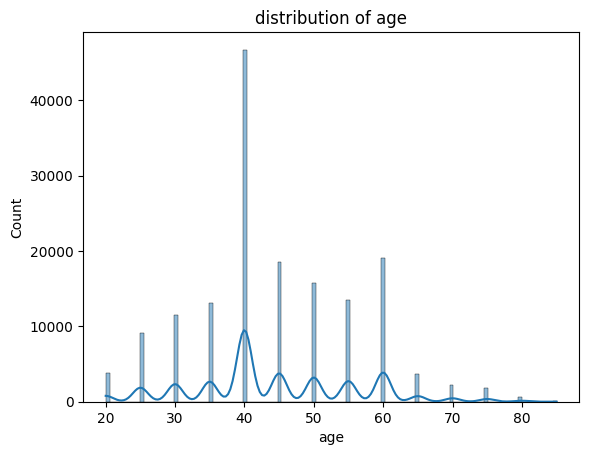

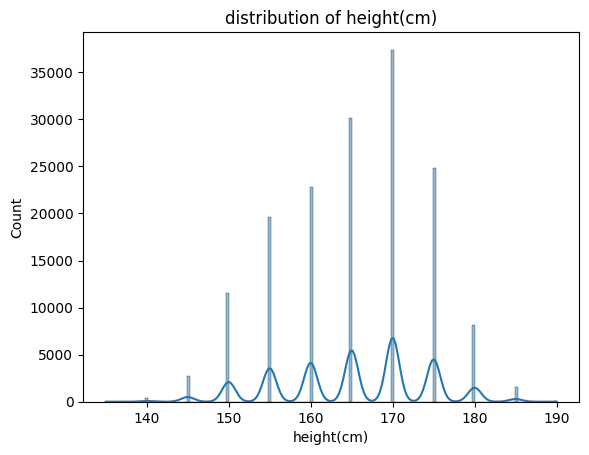

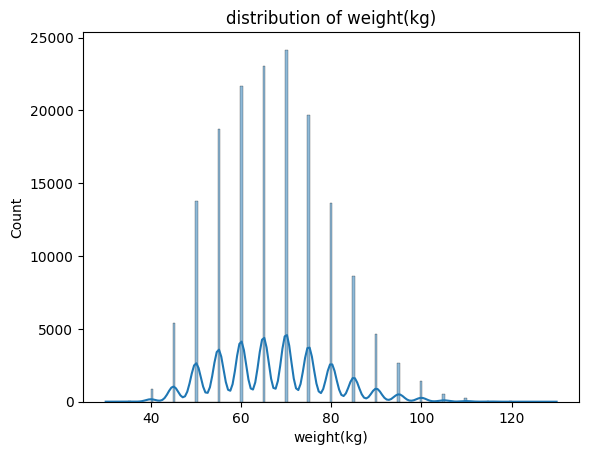

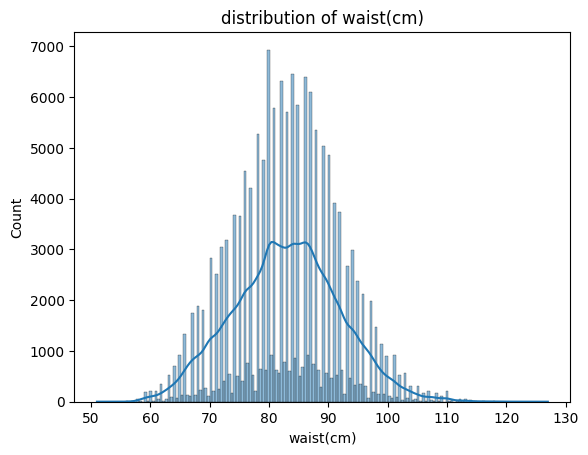

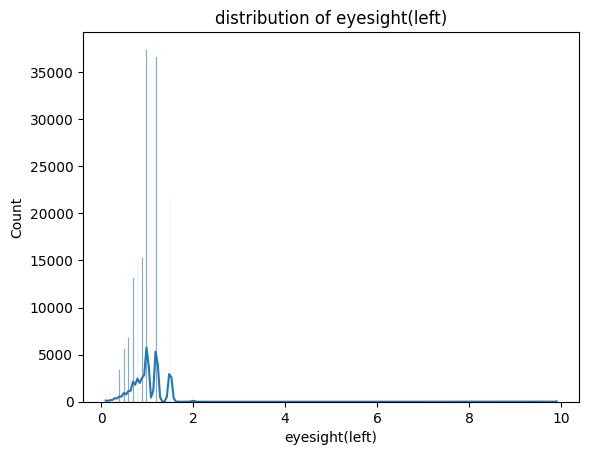

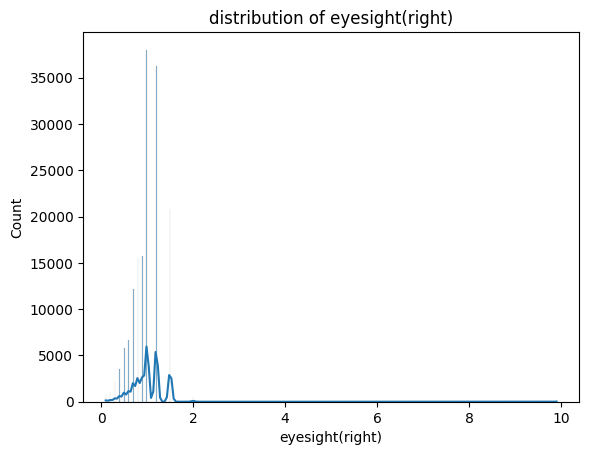

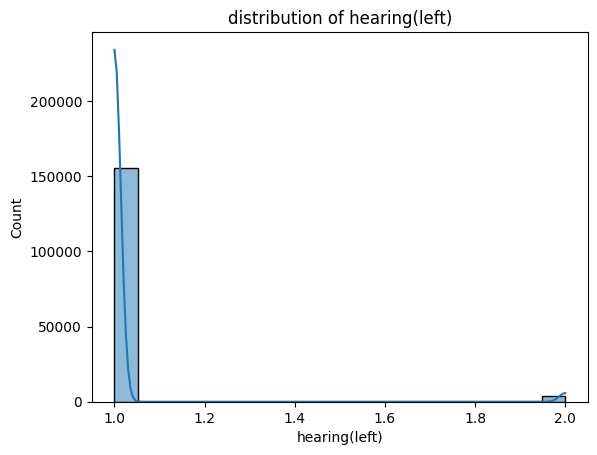

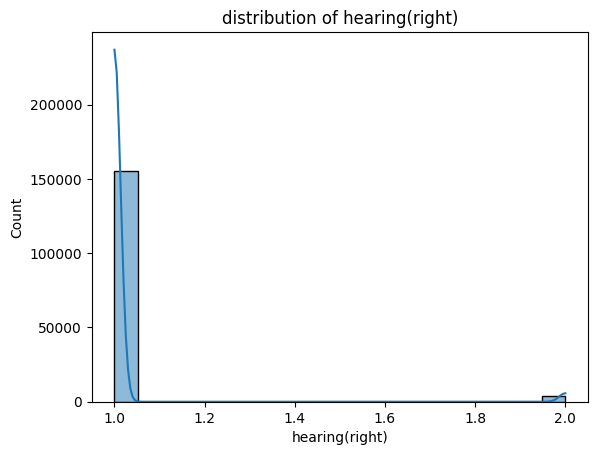

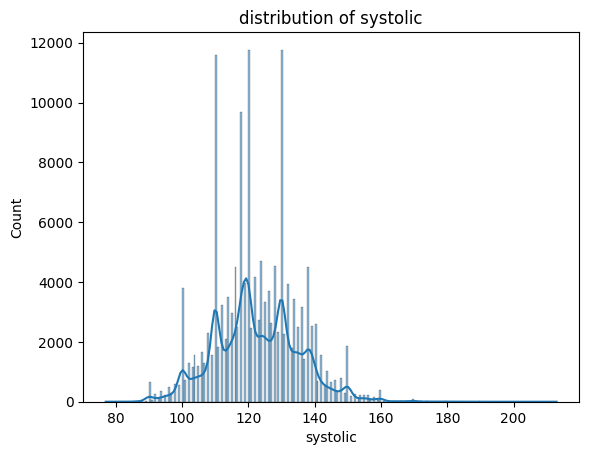

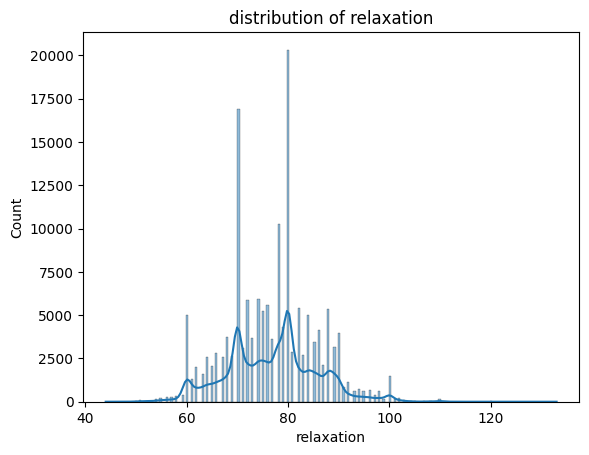

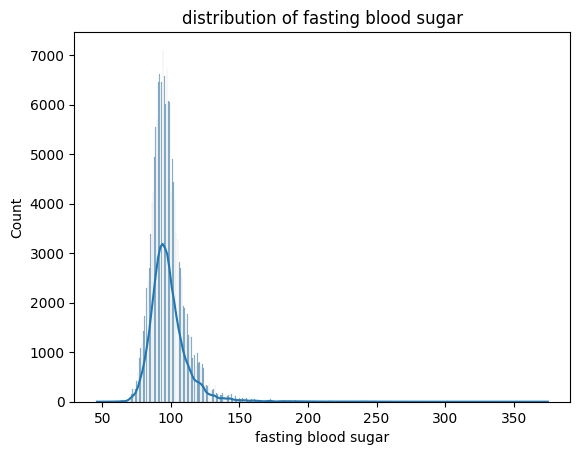

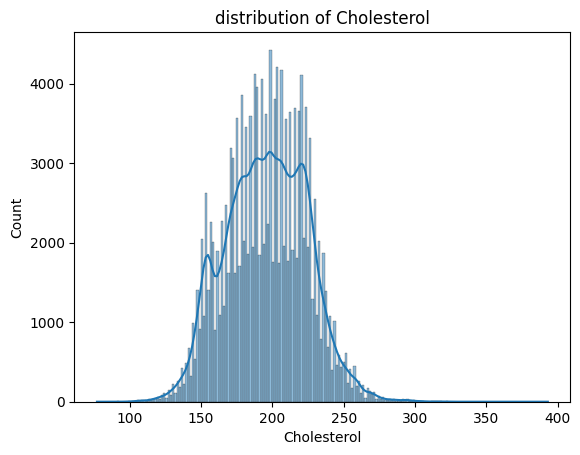

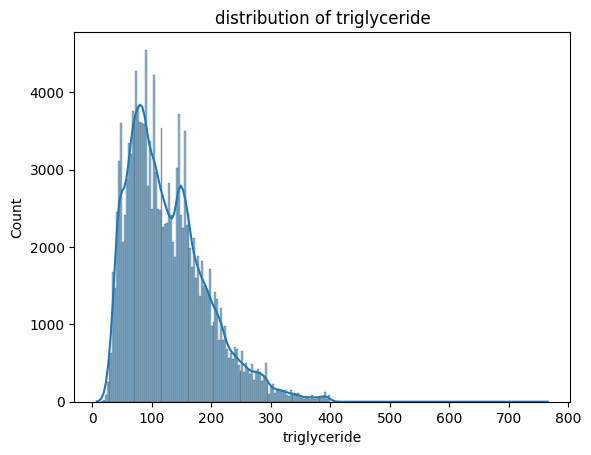

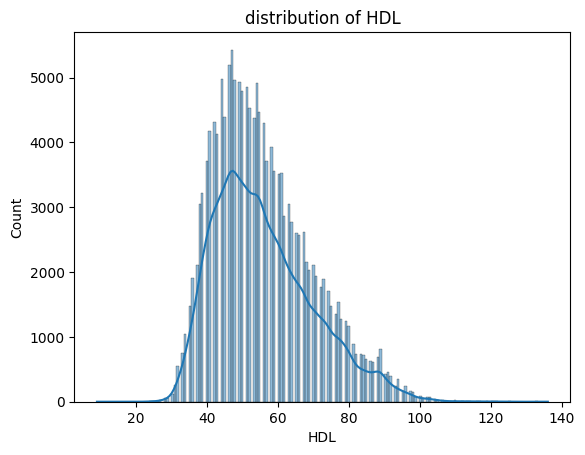

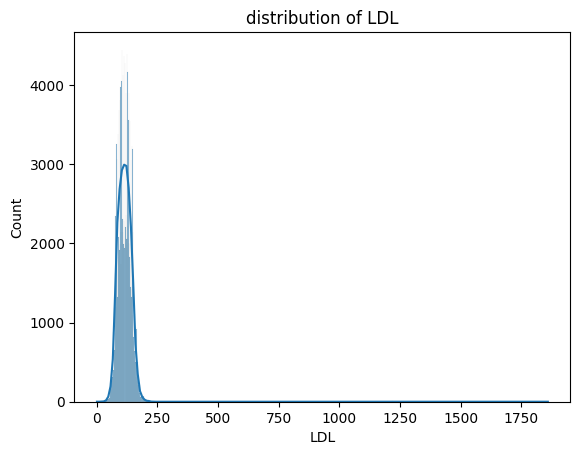

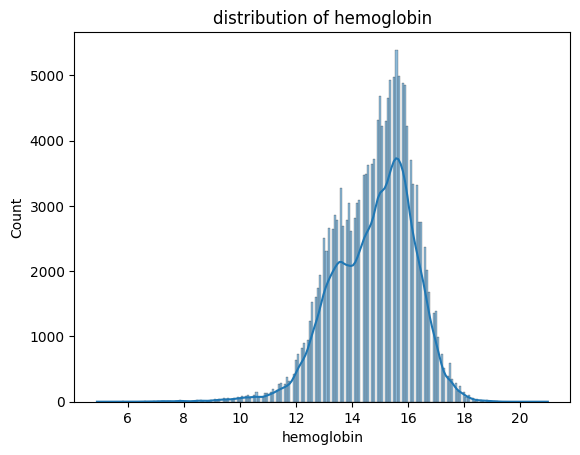

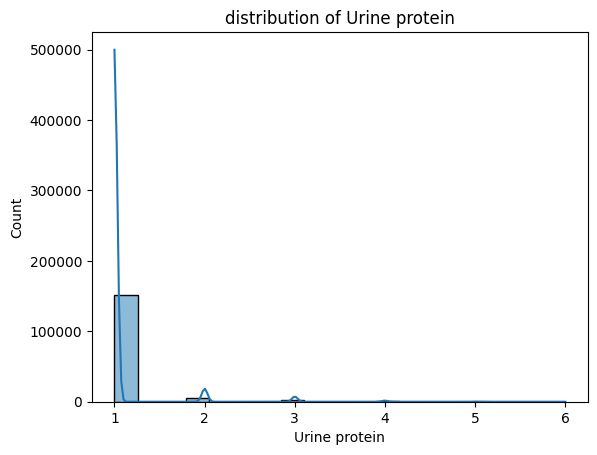

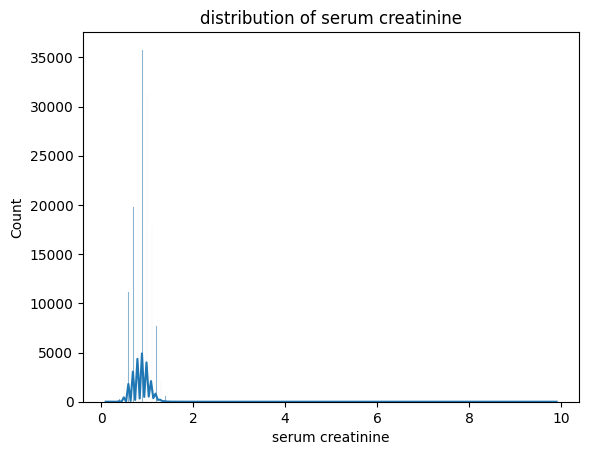

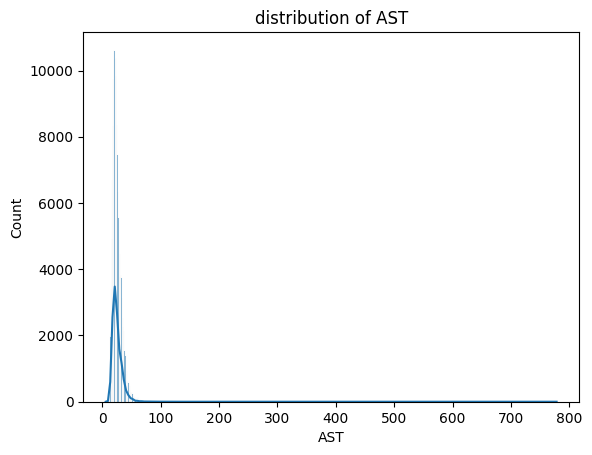

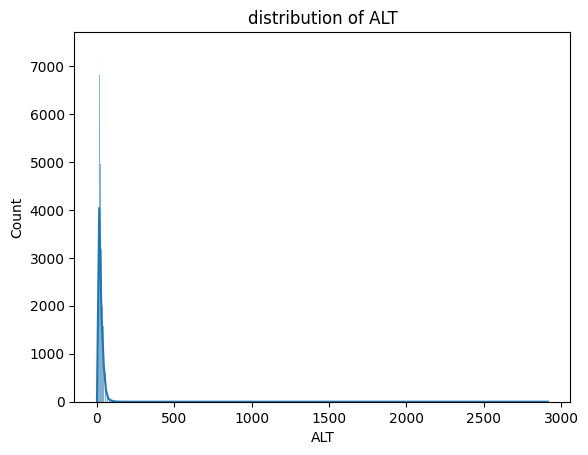

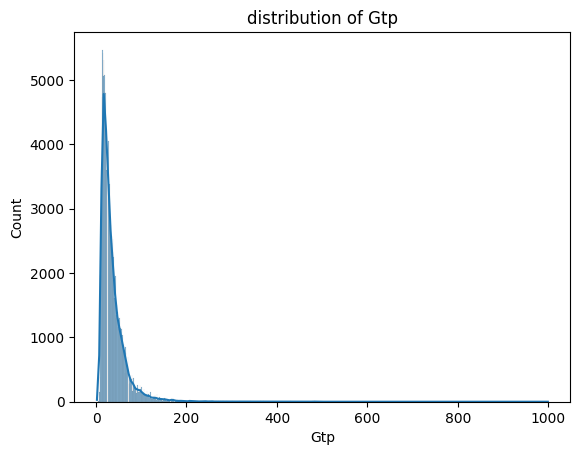

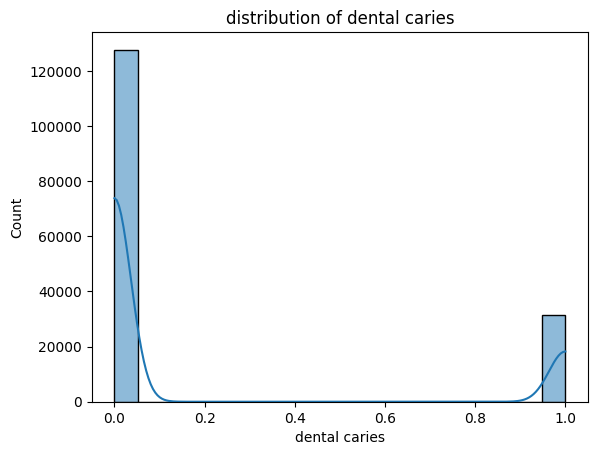

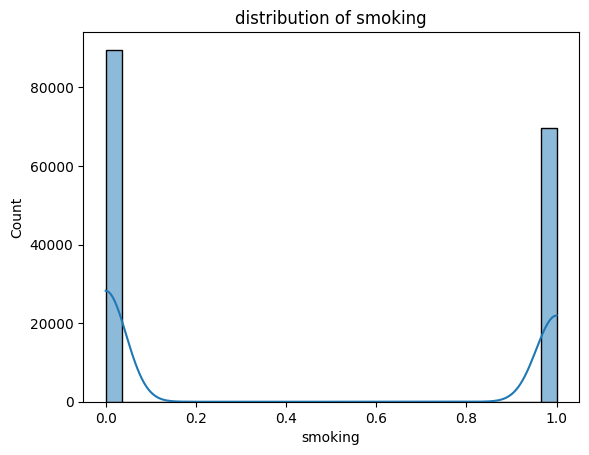

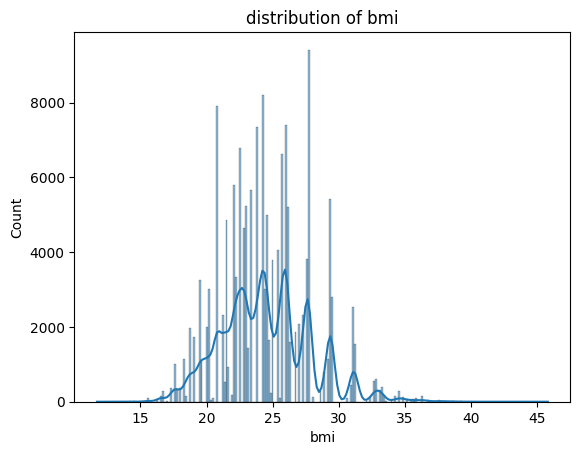

In [12]:
for i in train.columns:
    sns.histplot(data=train,x=i,kde=True)
    plt.title(f'distribution of {i}')
    plt.show()

In [13]:
x = train.drop('smoking',axis=1)
l = list(x.columns)
y = np.ravel(train['smoking'])

# Scaling

In [14]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
x = scale.fit_transform(x)

# Model selection

In [15]:
from sklearn.model_selection import train_test_split
X_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=55)
print(X_train.shape,y_train.shape)

(111479, 23) (111479,)


# Model 1 -> Random forest classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(
    n_estimators=300,       
    criterion='gini',      
    max_depth=10,         
    min_samples_split=3,    
    min_samples_leaf=4,     
    random_state=15,
    max_features='log2',
    class_weight='balanced'
)
random_forest_model.fit(X_train, y_train)
print(metrics.roc_auc_score(random_forest_model.predict(x_test),y_test))

0.7821465778162946


# Model 2 -> Catboost

In [17]:
from catboost import CatBoostClassifier

cbc = CatBoostClassifier(n_estimators=5000, learning_rate = 0.05, random_state=2311, verbose=0)
cbc.fit(X_train, y_train)
cbc_preds = cbc.predict(x_test)
print("CatBoost AUC:", metrics.roc_auc_score(cbc_preds, y_test))

CatBoost AUC: 0.7825076973164734


# Model 3 -> Lgbm classifier

In [18]:
from lightgbm import LGBMClassifier

lgbmc = LGBMClassifier(n_estimators=5000, learning_rate = 0.05, random_state=2311)
lgbmc.fit(X_train, y_train)
lgbmc_preds = lgbmc.predict(x_test)
print("CatBoost AUC:", metrics.roc_auc_score(lgbmc_preds, y_test))

CatBoost AUC: 0.7791740736085014


# Prepping test data for Predictions

In [19]:
t =test
test = test[l]
test = scale.fit_transform(test)

# Predictions

In [20]:
def makepred(test_data):
    cbc.fit(x,y)
    preds = cbc.predict(test_data)
    if len(preds) == len(t):
        new_df = pd.DataFrame({'id': t['id']})
        new_df['smoking'] = preds
        new_df.to_csv('SUBMISSION.csv', index=False)
        return"All is well"
    else:
        print(len(preds),len(z))
        return"error predictions and id's not same shape"

In [21]:
makepred(test)

'All is well'